In [1]:
import sys
sys.path.append('..')
from src.pomdp import *

In [2]:
import numpy as np
import random

# POMDP Toy Problem

Symmetric 3 state, 2 action model

## Model definition

In [3]:
ACTION_COUNT = 2
STATE_COUNT = 3

In [4]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.8, 0.1, 0.1],
       [0.1, 0.8, 0.1],
       [0.1, 0.1, 0.8]])

In [5]:
OBS_RND = 0.7 # 70% of observation success
def observation_function(s_p, a, o):
    return OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = observation_function(s_p, a, o)
          
observation_table[:,0,:]

array([[0.7 , 0.15, 0.15],
       [0.15, 0.7 , 0.15],
       [0.15, 0.15, 0.7 ]])

In [6]:
REWARD_PROBS = [0.2, 0.6]

def reward_function(s, a):
    tot = 0.0
    for s_p in range(STATE_COUNT):
        tot += (REWARD_PROBS[s_p] * transition_table[s,a,s_p])
    return tot

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        reward_table[s,a] = reward_function(s,a)
        
reward_table

array([[0.32, 0.53],
       [0.25, 0.32],
       [0.53, 0.25]])

In [8]:
states = ['s0','s1','s2']
actions = ['left', 'right']

model = POMDP_Model(states, actions, transition_table, reward_table, observation_table)

## Solving

In [9]:
solver = PBVI_Solver(model)

In [10]:
value_function = solver.solve(10,4)

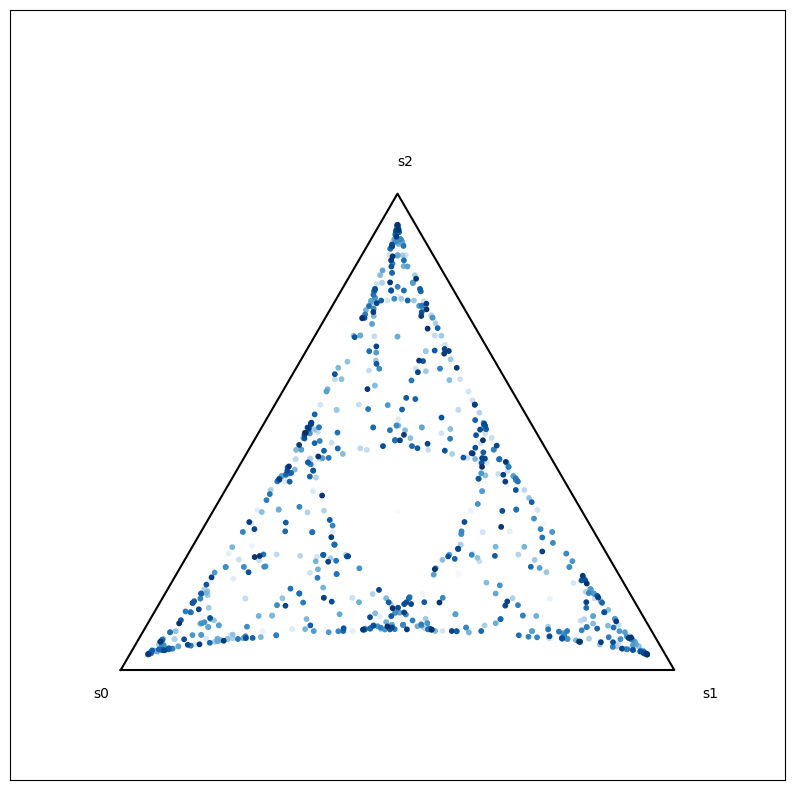

In [11]:
solver.plot_belief_set(10)

In [12]:
value_function

[AlphaVector([4.08880695, 3.93570242, 3.88730385]),
 AlphaVector([3.92750471, 3.88342448, 4.09431815]),
 AlphaVector([4.05695869, 3.95350654, 3.87245228]),
 AlphaVector([4.09436848, 3.9274631 , 3.88308729]),
 AlphaVector([4.09431815, 3.92750471, 3.88342448]),
 AlphaVector([4.04424536, 3.96529799, 3.79414163]),
 AlphaVector([3.9355266 , 3.8847061 , 4.08973213]),
 AlphaVector([4.08951298, 3.93581538, 3.88471583]),
 AlphaVector([3.92751549, 3.88564328, 4.09372439]),
 AlphaVector([3.9274631 , 3.88308729, 4.09436848]),
 AlphaVector([3.93581538, 3.88471583, 4.08951299]),
 AlphaVector([4.09372439, 3.92751549, 3.88564328]),
 AlphaVector([4.09437404, 3.92740597, 3.88302788]),
 AlphaVector([4.05695975, 3.95350674, 3.87244897]),
 AlphaVector([4.08878632, 3.93592777, 3.88701651]),
 AlphaVector([3.92740597, 3.88302788, 4.09437404]),
 AlphaVector([4.08973213, 3.9355266 , 3.8847061 ]),
 AlphaVector([4.08951299, 3.93581538, 3.88471583]),
 AlphaVector([3.92751438, 3.88560458, 4.09374379]),
 AlphaVector

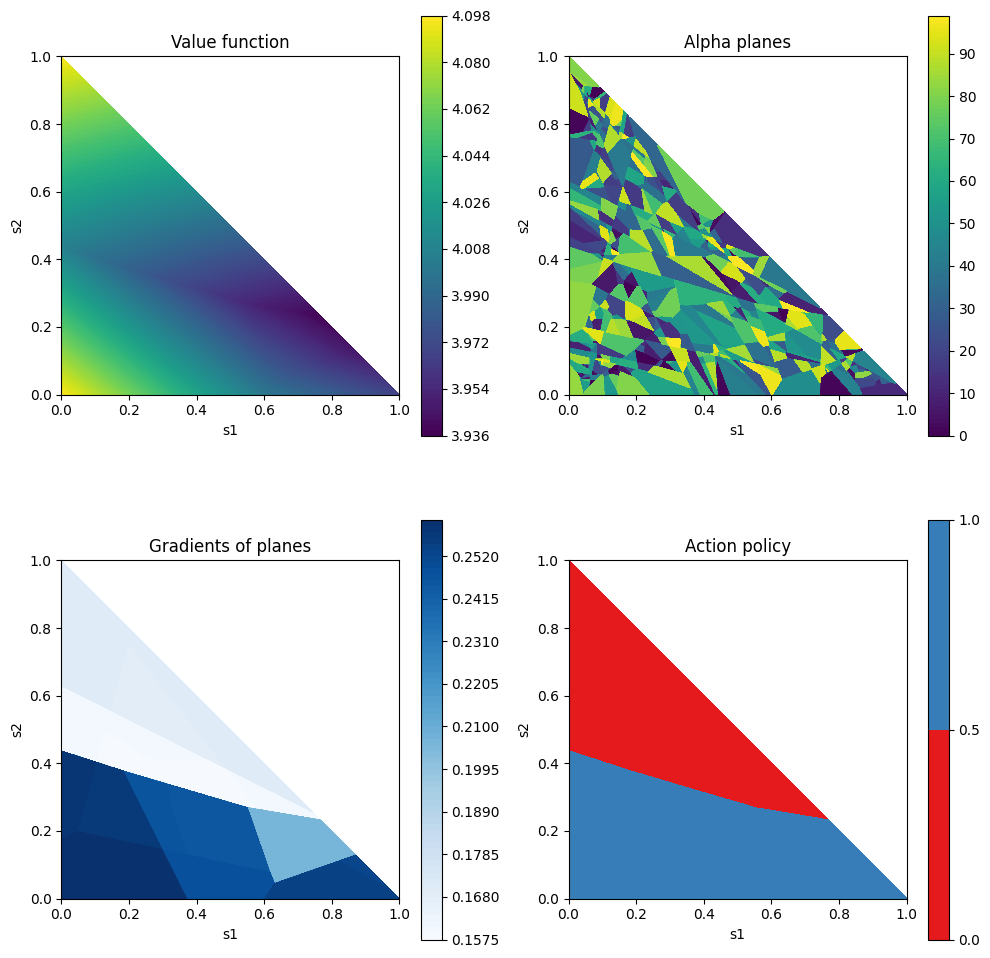

In [12]:
value_function.plot(3)

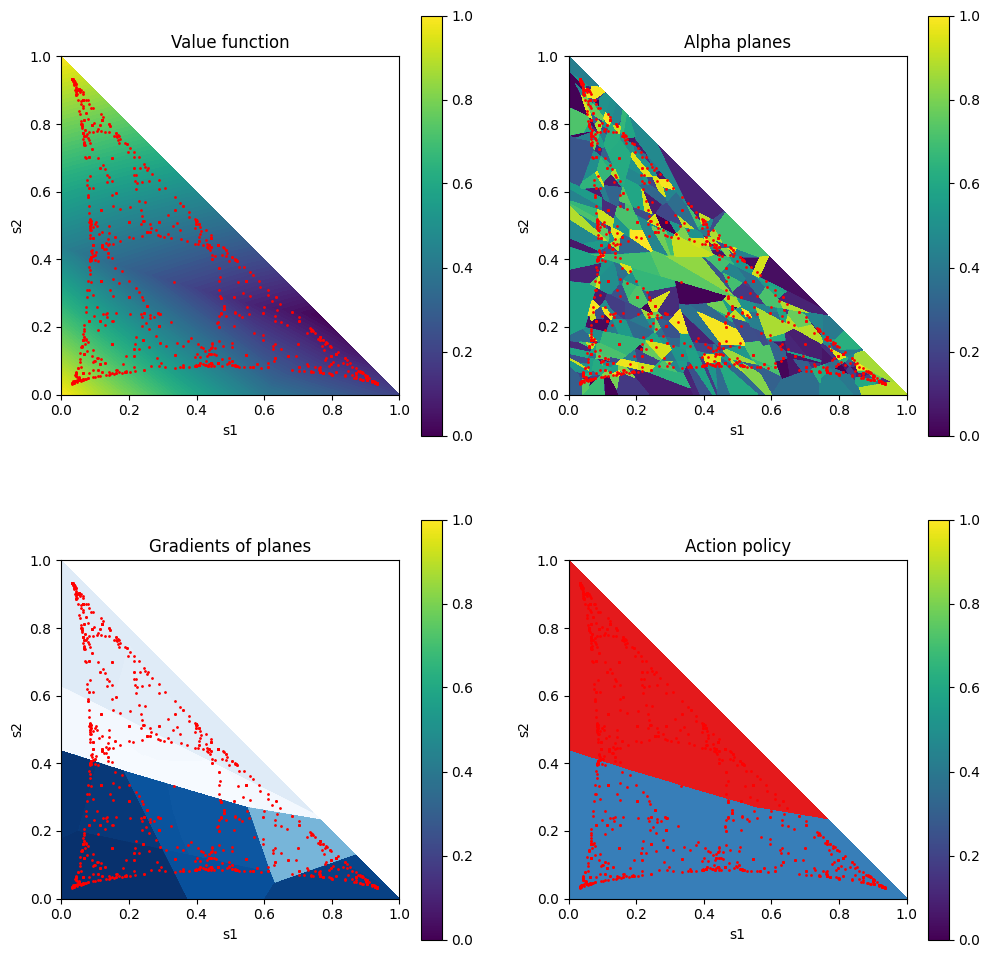

In [13]:
value_function.plot(3, solver.explored_beliefs)